In [18]:
import pandas               as pd
import matplotlib.pyplot    as plt
import numpy                as np

training_image_path = 'datasets/training/'
training_tnf_csv    = 'training_data/tps'

train_pd = pd.read_csv(training_tnf_csv + '/train.csv') 

/var/folders/tl/_smmzcf56jn3pnwyc8ggqhdc0000gn/T/ipykernel_89072/1535637522.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transforms_pd = transforms_pd.append({
/var/folders/tl/_smmzcf56jn3pnwyc8ggqhdc0000gn/T/ipykernel_89072/1535637522.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transforms_pd = transforms_pd.append({
/var/folders/tl/_smmzcf56jn3pnwyc8ggqhdc0000gn/T/ipykernel_89072/1535637522.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transforms_pd = transforms_pd.append({
/var/folders/tl/_smmzcf56jn3pnwyc8ggqhdc0000gn/T/ipykernel_89072/1535637522.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transforms_pd =

1: -1.1 to -0.901
2: -1.1 to -0.901
3: -1.1 to -0.9
4: -1.1 to -0.901
5: -1.1 to -0.9
6: -1.1 to -0.9
7: -0.7 to -0.5
8: -0.699 to -0.501
9: -0.699 to -0.5
10: -0.7 to -0.5
11: -0.699 to -0.5
12: -0.7 to -0.5
13: -0.3 to -0.1
14: -0.3 to -0.1
15: -0.3 to -0.1
16: -0.3 to -0.101
17: -0.3 to -0.1
18: -0.299 to -0.1
19: 0.1 to 0.3
20: 0.1 to 0.3
21: 0.1 to 0.3
22: 0.1 to 0.299


/var/folders/tl/_smmzcf56jn3pnwyc8ggqhdc0000gn/T/ipykernel_89072/1535637522.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transforms_pd = transforms_pd.append({
/var/folders/tl/_smmzcf56jn3pnwyc8ggqhdc0000gn/T/ipykernel_89072/1535637522.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transforms_pd = transforms_pd.append({
/var/folders/tl/_smmzcf56jn3pnwyc8ggqhdc0000gn/T/ipykernel_89072/1535637522.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transforms_pd = transforms_pd.append({
/var/folders/tl/_smmzcf56jn3pnwyc8ggqhdc0000gn/T/ipykernel_89072/1535637522.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transforms_pd =

23: 0.1 to 0.3
24: 0.1 to 0.3
25: 0.501 to 0.7
26: 0.5 to 0.699
27: 0.5 to 0.7
28: 0.5 to 0.7
29: 0.5 to 0.7
30: 0.5 to 0.7
31: 0.9 to 1.1
32: 0.901 to 1.1
33: 0.9 to 1.1
34: 0.9 to 1.1
35: 0.901 to 1.1
36: 0.9 to 1.1
37: -1.1 to -0.9
38: -0.7 to -0.5
39: -0.3 to -0.101
40: 0.101 to 0.3
41: 0.5 to 0.7
42: 0.9 to 1.1
43: -1.1 to -0.9
44: -0.7 to -0.5
45: -0.299 to -0.1
46: 0.1 to 0.3
47: 0.5 to 0.7
48: 0.9 to 1.1
49: -1.1 to -0.9
50: -0.7 to -0.501
51: -0.3 to -0.1
52: 0.1 to 0.3
53: 0.5 to 0.7
54: 0.9 to 1.1
55: -1.1 to -0.9
56: -0.7 to -0.5
57: -0.3 to -0.1
58: 0.1 to 0.3
59: 0.5 to 0.7
60: 0.9 to 1.1
61: -1.1 to -0.901
62: -0.7 to -0.5
63: -0.3 to -0.1
64: 0.1 to 0.299
65: 0.5 to 0.699
66: 0.9 to 1.1
67: -1.1 to -0.9
68: -0.7 to -0.5
69: -0.3 to -0.101
70: 0.1 to 0.3
71: 0.501 to 0.7
72: 0.901 to 1.1


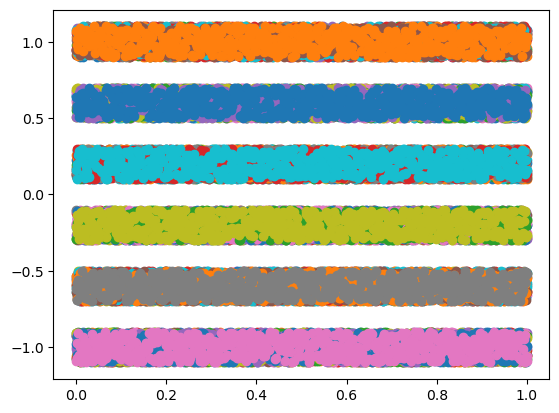

In [83]:
transforms_pd = pd.DataFrame(columns=['Parameter','Min','Max'])

# Find the min & max values of each parameter
for i in range(1,73):
    name = 't' + str(i)
    data = train_pd[name]
    plt.scatter(np.linspace(0, 1, len(data)), data)
    
    transforms_pd = transforms_pd.append({
        'Parameter': name, 
        'Min':       np.amin(data), 
        'Max':       np.amax(data)    
        }, ignore_index=True)
    

In [89]:
def random_transform(pd='', image_name='', min_max=[], name=True):
    """
    Create a random transform by sampling from each parameter. 
    Assume a uniform distribution between min & max values.
    """
    
    output = {}
    if name:
        output['ImageA'] = image_name
        output['ImageB'] = image_name
        
    if min_max.any():
        for i in range(1,19):
            name    = 't' + str(i)
            value   = np.random.uniform(min_max[0,i-1], min_max[1,i-1])
            output[name] = [value]
            
    else:
        for i in range(1,73):
            name    = 't' + str(i)
            row     = pd[pd['Parameter']==name]
            value   = np.random.uniform(row['Min'], row['Max'])[0]
            output[name] = [value]
            
    
        
    return output

### Add MRI images

In [21]:
file_names = ['HMU_003_DB', 'HMU_011_MQ', 'HMU_025_SH']

in_vivo = {
    'HMU_003_DB': [20,19,12],
    'HMU_007_TN': [19,18,16],
    'HMU_010_FH' : [19,17,13,12],
    'HMU_011_MQ': [18,12,10,9],
    'HMU_025_SH': [22,19,15]
}

updated_train_pd = train_pd.copy()
number_samples   = 0

for name in file_names:
    # MRI 
    mri_slices = in_vivo[name]
    for slice in mri_slices:
        image_name  = 'mri_' + name + '_' + str(slice) + '.png'
        new_row     = random_transform(transforms_pd, image_name)
        
        new_row_pd       = pd.DataFrame.from_dict(new_row)
        updated_train_pd = pd.concat((updated_train_pd, new_row_pd), ignore_index=True)
        
        number_samples += 1

### Add histology images

In [22]:
file_names = ['HMU_003_DB', 'HMU_011_MQ', 'HMU_025_SH','HMU_056_JH','HMU_060_CH','HMU_063_RS','HMU_064_SB','HMU_065_RH','HMU_067_MS']

updated_train_pd = train_pd.copy()
number_samples   = 0

histo = {
    'HMU_003_DB': ['_A1', '_A2','_A3','_A5'],
    'HMU_011_MQ': ['_4','_5','_6','_7','_8','_9'],
    'HMU_025_SH': ['A1','A3','A4','A5'],
    'HMU_056_JH': ['A1','A2','A3','A4','A5','A6'], 
    'HMU_060_CH': ['A1','A2','A3','A4','A5','A6'], 
    'HMU_063_RS': ['A1','A2','A3','A4','A5'], 
    'HMU_064_SB': ['A1','A4','A6'], 
    'HMU_065_RH': ['A1','A2','A3','A4','A5','A6'], 
    'HMU_067_MS': ['A1','A2','A3','A4','A5','A6','A7']
}

for i in range(10):
    for name in file_names: 
        histo_slices = histo[name]
        for slice in histo_slices:
            image_name  = name + str(slice) + '_segmented.png'
            new_row     = random_transform(transforms_pd, image_name)
            
            new_row_pd       = pd.DataFrame.from_dict(new_row)
            updated_train_pd = pd.concat((updated_train_pd, new_row_pd), ignore_index=True)
            
            number_samples += 1

print(number_samples)
updated_train_pd

updated_train_pd.to_csv('training_data/tps/train_updated_47.csv', index=False)

470


### Illustrate TPS transforms 

In [77]:
from process_img import * 
from geotnf.transformation import GeometricTnf
from skimage import io


def tps_transform_grid(transforms_pd):
    """
    Apply a random TPS transform to the sample grid
    """
    
    transform = random_transform(transforms_pd, name=False)
    theta_tps = [transform[i] for i in transform]
    theta_tps = torch.Tensor(np.transpose(theta_tps))

    # Preprocess image 
    source_image = io.imread('../Dataset/Data/grid.png')
    source_image = np.squeeze(source_image[:,:,:3])
    source_image[source_image<250] = 0
    source_image = process_image(source_image, use_cuda=False, high_res=True)

    # TPS transformation
    tpsTnf       = GeometricTnf(geometric_model='tps', out_h=400, out_w=400, use_cuda=False)
    warped_image = tpsTnf(source_image,theta_tps)
        
    # Un-normalize images and convert to numpy
    warped_image_np = normalize_image(warped_image,forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
        
    # Ignore negative values
    warped_image_np[warped_image_np < 0] = 0    
    source_image = source_image.permute(0,2,3,1)
    return source_image, warped_image_np

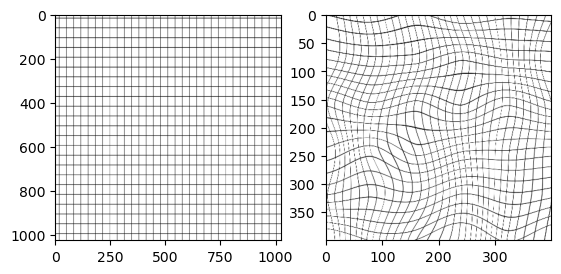

In [78]:
source_image, warped_image = tps_transform_grid(transforms_pd)

fig, axs = plt.subplots(1,2)
axs[0].imshow(np.squeeze(source_image))
axs[1].imshow(warped_image)

In [74]:
from process_img import * 
from geotnf.transformation import GeometricTnf
from skimage import io
from torch.nn.functional import normalize

def tps_Grid(theta_tps, norm=False):
    """
    Apply a random TPS transform to the sample grid
    """
    
    theta_tps = torch.Tensor(theta_tps)
    if norm:
        theta_tps = normalize(theta_tps)
        print(theta_tps)


    # Preprocess image 
    source_image = io.imread('../Dataset/Data/grid.png')
    source_image = np.squeeze(source_image[:,:,:3])
    source_image[source_image<250] = 0
    source_image = process_image(source_image, use_cuda=False, high_res=True)

    # TPS transformation
    tpsTnf_mri   = GeometricTnf(geometric_model='tps-mri', out_h=400, out_w=400, use_cuda=False)
    warped_image = tpsTnf_mri(source_image,theta_tps)
        
    # Un-normalize images and convert to numpy
    warped_image_np = normalize_image(warped_image,forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
        
    # Ignore negative values
    warped_image_np[warped_image_np < 0] = 0    
    source_image = source_image.permute(0,2,3,1)
    return source_image, warped_image_np

/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor([[-0.0842, -0.2247,  0.0778,  0.1140, -0.3184, -0.5353, -0.0076,  0.2082,
          0.2586, -0.3105,  0.1974,  0.2487, -0.1989, -0.2711,  0.2789,  0.1030,
         -0.0544,  0.1533]])


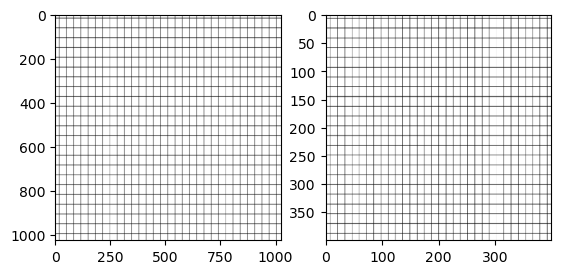

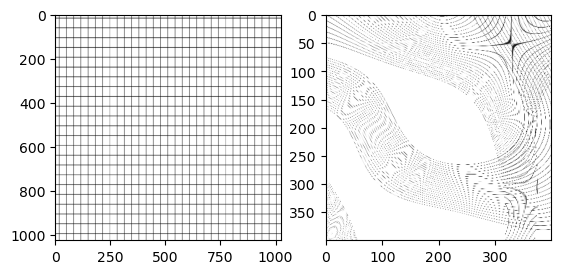

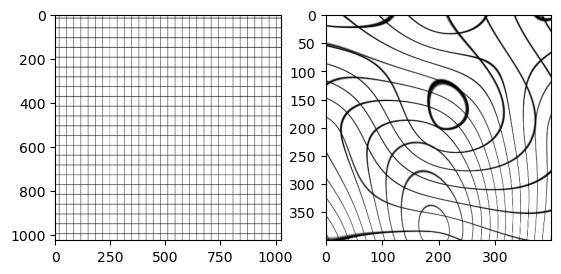

In [79]:
tps =[
            [
                -0.6362779140472412,
                -1.6981632709503174,
                0.587742805480957,
                0.8616968393325806,
                -2.4061849117279053,
                -4.045632839202881,
                -0.05718374252319336,
                1.5738213062286377,
                1.9545316696166992,
                -2.3466782569885254,
                1.491770625114441,
                1.8796687126159668,
                -1.5033074617385864,
                -2.048987865447998,
                2.108168601989746,
                0.7781451940536499,
                -0.4112209379673004,
                1.1588855981826782
            ]
        ]
tps_test =[[-1.0,-1.0,-1.0,0.0,0.0,0.0,1.0,1.0,1.0,-1.0,0.0,1.0,-1.0,0.0,1.0,-1.0,0.0,1.0]]

source, warped = tps_Grid(tps_test)
fig, axs = plt.subplots(1,2)
axs[0].imshow(np.squeeze(source))
axs[1].imshow(warped)

source, warped = tps_Grid(tps)
fig, axs = plt.subplots(1,2)
axs[0].imshow(np.squeeze(source))
axs[1].imshow(warped)

source, warped = tps_Grid(tps, norm=True)
fig, axs = plt.subplots(1,2)
axs[0].imshow(np.squeeze(source))
axs[1].imshow(warped)

### MRI training data

In [ ]:
import glob

columns = ['ImageA','ImageB']
for i in range(1,73):
    columns.append('t' + str(i))
    
train_mri_pd = pd.DataFrame(columns=columns)
test_mri_pd  = pd.DataFrame(columns=columns)

number_samples   = 0

file_names =  [i[20:] for i in sorted(glob.glob('./datasets/training/mri_*'))]

for i in range(10):
    count = 0
    for name in file_names: 
        new_row     = random_transform(transforms_pd, name)
        new_row_pd  = pd.DataFrame.from_dict(new_row)
        
        if count < 61:
            train_mri_pd = pd.concat((train_mri_pd, new_row_pd), ignore_index=True)
        else:
            test_mri_pd  = pd.concat((test_mri_pd, new_row_pd), ignore_index=True)
    
        number_samples += 1
        count          += 1

print(number_samples)
train_mri_pd.to_csv('training_data/tps/mri_train.csv', index=False)
test_mri_pd.to_csv('training_data/tps/mri_test.csv', index=False)
test_mri_pd


820


,ImageA,ImageB,t1,t2,t3,t4,t5,t6,t7,t8,...,t63,t64,t65,t66,t67,t68,t69,t70,t71,t72
0,mri_TCIA-0021_09.jpg,mri_TCIA-0021_09.jpg,-1.008367,-1.054707,-0.942675,-0.968491,-1.049444,-0.924799,-0.659288,-0.542270,...,-0.147489,0.260593,0.612017,1.079344,-1.036750,-0.690782,-0.226243,0.274781,0.628379,1.002083
1,mri_TCIA-0021_10.jpg,mri_TCIA-0021_10.jpg,-0.996976,-0.956464,-1.028766,-1.083395,-0.943323,-1.002217,-0.679270,-0.552192,...,-0.288744,0.100280,0.651726,0.954001,-0.900413,-0.565001,-0.138385,0.103915,0.631452,0.977195
2,mri_TCIA-0021_11.jpg,mri_TCIA-0021_11.jpg,-1.092360,-1.044288,-0.914137,-1.030593,-0.972014,-1.069282,-0.670937,-0.571004,...,-0.260032,0.203843,0.669532,1.074024,-0.936722,-0.677353,-0.154561,0.245882,0.568576,0.991508
3,mri_TCIA-0021_12.jpg,mri_TCIA-0021_12.jpg,-1.005393,-1.022066,-1.018239,-1.026573,-0.960166,-0.938544,-0.550997,-0.652634,...,-0.126175,0.227872,0.697144,0.916429,-1.065591,-0.501847,-0.253359,0.215503,0.685727,1.023440
4,mri_TCIA-0021_13.jpg,mri_TCIA-0021_13.jpg,-1.070546,-0.941964,-1.061482,-1.058674,-1.071907,-1.024241,-0.625985,-0.524939,...,-0.220528,0.173528,0.510662,1.018361,-0.936542,-0.522919,-0.110605,0.273816,0.597664,0.981572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,mri_TCIA-0025_11.jpg,mri_TCIA-0025_11.jpg,-1.066310,-0.961148,-0.988854,-1.035713,-1.006756,-1.076686,-0.531722,-0.572219,...,-0.142655,0.133049,0.578103,0.958442,-0.932310,-0.638003,-0.166703,0.110212,0.659319,1.072591
206,mri_TCIA-0025_12.jpg,mri_TCIA-0025_12.jpg,-1.079777,-0.980818,-1.088046,-0.985932,-1.044226,-0.999965,-0.642118,-0.591860,...,-0.189629,0.290755,0.667818,1.059314,-0.908971,-0.656791,-0.160558,0.146619,0.545127,1.086133
207,mri_TCIA-0025_13.jpg,mri_TCIA-0025_13.jpg,-1.029759,-0.943797,-1.043342,-0.920965,-0.964403,-1.022140,-0.545756,-0.599129,...,-0.181504,0.197011,0.677276,0.926632,-1.093569,-0.666536,-0.161725,0.131821,0.541270,0.970608
208,mri_TCIA-0026_10.jpg,mri_TCIA-0026_10.jpg,-0.934363,-0.968913,-1.044015,-1.083533,-1.025803,-1.003269,-0.686998,-0.641879,...,-0.137724,0.194267,0.655919,0.998234,-0.908784,-0.573672,-0.131530,0.218059,0.549072,1.002952


In [90]:
import glob

min_max = [[-1.1, -1.1, -1.1, -0.1, -0.1, -0.1, 0.9, 0.9, 0.9,-1.1, -0.1, 0.9,-1.1, -0.1, 0.9,-1.1, -0.1, 0.9],
            [-0.9, -0.9, -0.9, 0.1,  0.1,  0.1, 1.1, 1.1, 1.1,-0.9, 0.1, 1.1,-0.9, 0.1, 1.1,-0.9, 0.1, 1.1]]

min_max = np.array(min_max)

columns = ['ImageA','ImageB']
for i in range(1,18):
    columns.append('t' + str(i))
    
train_mri_pd = pd.DataFrame(columns=columns)
test_mri_pd  = pd.DataFrame(columns=columns)

number_samples   = 0

file_names =  [i[20:] for i in sorted(glob.glob('./datasets/training/mri_*'))]

for i in range(10):
    count = 0
    for name in file_names: 
        new_row     = random_transform(image_name=name, min_max=min_max)
        new_row_pd  = pd.DataFrame.from_dict(new_row)
        
        if count < 61:
            train_mri_pd = pd.concat((train_mri_pd, new_row_pd), ignore_index=True)
        else:
            test_mri_pd  = pd.concat((test_mri_pd, new_row_pd), ignore_index=True)
    
        number_samples += 1
        count          += 1

print(number_samples)
train_mri_pd.to_csv('training_data/tps/mri_train.csv', index=False)
test_mri_pd.to_csv('training_data/tps/mri_test.csv', index=False)
test_mri_pd



820


,ImageA,ImageB,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18
0,mri_TCIA-0021_09.jpg,mri_TCIA-0021_09.jpg,-0.989288,-1.074552,-1.099794,0.094547,-0.052790,-0.059091,1.059049,0.956784,1.077007,-0.920127,0.086312,1.058541,-0.957674,-0.068520,1.089964,-0.979396,0.063573,0.914259
1,mri_TCIA-0021_10.jpg,mri_TCIA-0021_10.jpg,-0.986136,-1.084391,-0.975855,-0.052134,-0.092611,-0.038604,1.092156,0.928315,1.044178,-0.990466,-0.062988,0.907503,-1.080204,-0.002770,1.002678,-0.941446,-0.025487,0.955369
2,mri_TCIA-0021_11.jpg,mri_TCIA-0021_11.jpg,-0.908299,-1.006595,-0.985663,0.015941,0.092046,-0.094357,0.945057,0.940750,1.023087,-1.059425,-0.051693,1.097098,-1.080105,0.067504,1.035147,-0.904876,-0.031660,0.973396
3,mri_TCIA-0021_12.jpg,mri_TCIA-0021_12.jpg,-0.980837,-1.080660,-1.043257,0.027314,-0.015762,0.015219,1.006706,0.950703,1.066326,-0.988690,0.086177,0.935776,-1.017347,-0.062519,1.019994,-1.032468,-0.050989,1.090084
4,mri_TCIA-0021_13.jpg,mri_TCIA-0021_13.jpg,-1.061210,-1.013145,-1.077686,0.037015,0.036234,0.082908,0.965901,1.082271,1.087811,-0.922874,0.081581,0.999311,-1.086126,-0.085400,0.948902,-0.989962,0.061641,1.035572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,mri_TCIA-0025_11.jpg,mri_TCIA-0025_11.jpg,-0.943224,-1.020305,-1.064882,-0.047988,-0.061580,-0.039625,1.017063,1.078940,1.005075,-1.074945,-0.070203,0.942191,-0.975810,-0.021949,0.962257,-1.019008,0.098367,0.907090
206,mri_TCIA-0025_12.jpg,mri_TCIA-0025_12.jpg,-1.030775,-1.083656,-0.946083,0.070275,0.024966,-0.008223,1.097387,1.051351,1.050988,-1.019729,0.041679,0.952752,-0.959577,-0.071516,1.013615,-1.028434,0.030320,0.975780
207,mri_TCIA-0025_13.jpg,mri_TCIA-0025_13.jpg,-1.088798,-0.962245,-0.944043,0.066838,0.066887,0.086565,0.952437,1.014164,1.074377,-1.030346,0.078321,1.026815,-0.905090,-0.033250,0.909223,-0.945309,0.016464,1.035312
208,mri_TCIA-0026_10.jpg,mri_TCIA-0026_10.jpg,-1.075397,-1.053639,-0.918701,-0.063182,0.029574,-0.059280,1.014009,0.950511,0.920206,-1.004501,-0.085260,1.044865,-0.951125,0.080178,1.079347,-1.026161,-0.040142,0.969447
